# MS3 - Baseline: Resnet50 + FCN
Authors: Harry Li, Yunxi Li, John Jun, Valentin Badea

### Installs and Imports

Here we will load necessary packages and any overhead installs required for the data access

In [236]:
import os
import sys
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm
import glob
import zipfile
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import pearsonr, ConstantInputWarning
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from sklearn.metrics import r2_score
import scipy.stats as stats

import spatialdata as sd 
import anndata as ad 
import scanpy as sc 
from skimage.measure import regionprops
import h5py

import torch
import timm 
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn as nn

import dask.array as da
import xarray as xr
from spatial_image import SpatialImage

### Data Loading

Loads in and stores the data objects in this note book for easier acess, might require some large memory

In [2]:
sdata = sd.read_zarr('raw/UC6_I.zarr/UC6_I.zarr')

/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [156]:
class PatchCells(Dataset):
    """
    This class takes in an histology image, 
    list of cell ids that is supposedly in that image
    a dictionary that maps cell ids to their centroid coordinates,
    and a patch size. 
    """
    def __init__(self, image, cell_ids, cell_coords, patch_size=32):
        self.image = image
        self.cell_ids = cell_ids
        self.cell_coords = cell_coords
        self.patch_size = patch_size

    # do a filtering of the cell ids
        self.valid_cell_ids = [id for id in cell_ids if id in cell_coords]

    def __len__(self):
        return len(self.valid_cell_ids)
        
    # takes in a cell id, returns a {key: cell id, value: patch in tensor format}
    def __getitem__(self, idx):
        cell_id = self.valid_cell_ids[idx]
        x, y = self.cell_coords[cell_id]

        half_patch = self.patch_size // 2

        # taking care of edge cases as well
        x_start = max(0, x - half_patch)
        x_end = min(self.image.shape[0], x + half_patch)
        y_start = max(0, y - half_patch)
        y_end = min(self.image.shape[1], y + half_patch)

        # create a 0 patch first
        patch = np.zeros((self.patch_size, self.patch_size, 3), dtype=np.float32)

        # populate with actual data, note the case where cell is at edge of image
        patch_from_in = self.image[y_start:y_end, x_start:x_end]
        patch[:patch_from_in.shape[0], :patch_from_in.shape[1], :] = patch_from_in 

        # normalize
        patch = patch / 255.0

        # pytorch tensor
        patch = np.transpose(patch, (2, 0, 1))

        return {
            'cell_id': cell_id,
            'patch': torch.tensor(patch, dtype=torch.float32)
        }
    
# pairs cell ids (according to the split we want) to their patches
# returns a dictionary of {key: cell id, value: patch} (same as PatchCells)
def get_patches(sdata, random_seed=209):
    # pull training cells ids into a list
    split_cell_id = sdata["cell_id-group"].obs.query("group == 'train'")["cell_id"].values

    # get mask, pull regions
    he_nuc_mask = sdata['HE_nuc_original'][0, :, :].to_numpy()
    regions = regionprops(he_nuc_mask)

    # pull centroid coordinate of each cell's regions
    # dict has key=cell id and value=centroid coordinate
    cell_coords = {}
    for props in regions:
        cid = props.label
        if cid in split_cell_id:
            y_center, x_center = int(props.centroid[0]), int(props.centroid[1])
            cell_coords[cid] = (x_center, y_center)

    # assemble the patch dataset
    he_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

    np.random.seed(random_seed)
    shuffled = np.random.permutation(split_cell_id)
    total_len = len(split_cell_id)
    train_len = int(0.7 * total_len)
    val_len = int(0.2 * total_len)
    train_ids = shuffled[:train_len]
    val_ids = shuffled[train_len:train_len + val_len]
    test_ids = shuffled[train_len + val_len:]

    # create dataset objects
    dataset_patch_train = PatchCells(he_image, train_ids, cell_coords, patch_size=32)
    dataset_patch_val = PatchCells(he_image, val_ids, cell_coords, patch_size=32)
    dataset_patch_test = PatchCells(he_image, test_ids, cell_coords, patch_size=32)

    return dataset_patch_train, dataset_patch_val, dataset_patch_test

def get_expression(sdata, dataset_patch):
    # get expression data
    gene_names = sdata['anucleus'].var['gene_symbols'].values
    gene_exp_matrix = sdata['anucleus'].X

    # need to pair up cell id with the cell's index in expression matrix
    cell_id_to_idx = {cell_id: i for i, cell_id in enumerate(sdata['anucleus'].obs['cell_id'].values)}
    valid_cell_ids = dataset_patch.valid_cell_ids
    valid_cell_idx = [cell_id_to_idx[cell_id] for cell_id in valid_cell_ids if cell_id in cell_id_to_idx] # taking the intercept just in case

    # subset expression matrix by filtered cell
    dataset_expression = gene_exp_matrix[valid_cell_idx]

    if sp.issparse(dataset_expression):
        dataset_expression = dataset_expression.toarray()
    return dataset_expression

def extract_features(loader, model):
    features = []
    cell_ids = []

    with torch.no_grad():
        for batch in loader:
            patches = batch['patch'].to('cuda')
            output = model(patches)
            
            # reshape
            output = output.squeeze()
            
            features.append(output.cpu().numpy())
            cell_ids.extend(batch['cell_id'])
    
    features = np.vstack(features)
    feature_cell_ids = np.array(cell_ids)
    return features, feature_cell_ids

# calculate r2 and pearson given y pred and y true
def compute_r2_pearson(y_true, y_pred):
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # r2 is easy we average across samples
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')

    # pearson we have to query each gene
    pearson = []
    for i in range(y_true.shape[1]):
        corr, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
        pearson.append(corr)
    mean_pearson = np.nanmean(pearson)

    return r2, mean_pearson

### Fit a simple FCN

In [152]:
# create train and val datasets
dataset_patch_train, dataset_patch_val, dataset_patch_test = get_patches(sdata)
dataset_expression_train = get_expression(sdata, dataset_patch_train)
dataset_expression_val = get_expression(sdata, dataset_patch_val)
dataset_expression_test = get_expression(sdata, dataset_patch_test)

# create dataloader
train_loader = DataLoader(dataset_patch_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_patch_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_patch_test, batch_size=32, shuffle=True)

# define resnet model
# pull resnet50, throw away last layer
model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
model_resnet = torch.nn.Sequential(*(list(model_resnet.children())[:-1]))
model_resnet.to('cuda')
model_resnet.eval()

# extract resnet embeddings
train_embeddings, train_cell_ids = extract_features(train_loader, model_resnet)
val_embeddings, val_cell_ids = extract_features(val_loader, model_resnet)
test_embeddings, test_cell_ids = extract_features(test_loader, model_resnet)

In [153]:
train_dataset = TensorDataset(
    torch.tensor(train_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_train, dtype=torch.float32)
)

val_dataset = TensorDataset(
    torch.tensor(val_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_val, dtype=torch.float32)
)

test_dataset = TensorDataset(
    torch.tensor(test_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_test, dtype=torch.float32) 
)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [157]:
# fit fcn model
resnet_feature_dim = train_embeddings.shape[1]
model = nn.Sequential(
    nn.Linear(resnet_feature_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 460)
)
model.to('cuda')

# some setups
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
val_losses = []

# es logic
best_r2 = float('inf')
patience = 5
counter = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))

    # validation
    model.eval()
    running_val_loss = 0.0
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to('cuda'), y_val.to('cuda')
            y_pred_val = model(x_val)
            val_loss = criterion(y_pred_val, y_val)
            running_val_loss += val_loss.item()

            y_true_all.append(y_val.cpu().numpy())
            y_pred_all.append(y_pred_val.cpu().numpy())
    val_losses.append(running_val_loss / len(val_loader))
    val_r2, val_pearson = compute_r2_pearson(y_true_all, y_pred_all)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val R2: {val_r2:.4f}, Val Pearson: {val_pearson:.4f}")
    
    if val_r2 < best_r2:
        best_r2 = val_r2
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# save the best model
model.load_state_dict(best_model_state)


Epoch 1, Train Loss: 0.1115, Val Loss: 0.1112, Val R2: -0.0016, Val Pearson: -0.0003
Epoch 2, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0009, Val Pearson: 0.0002
Epoch 3, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0008, Val Pearson: 0.0006
Epoch 4, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0009, Val Pearson: 0.0004
Epoch 5, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0010, Val Pearson: 0.0004
Epoch 6, Train Loss: 0.1110, Val Loss: 0.1111, Val R2: -0.0014, Val Pearson: 0.0006
Early stopping at epoch 6


<All keys matched successfully>

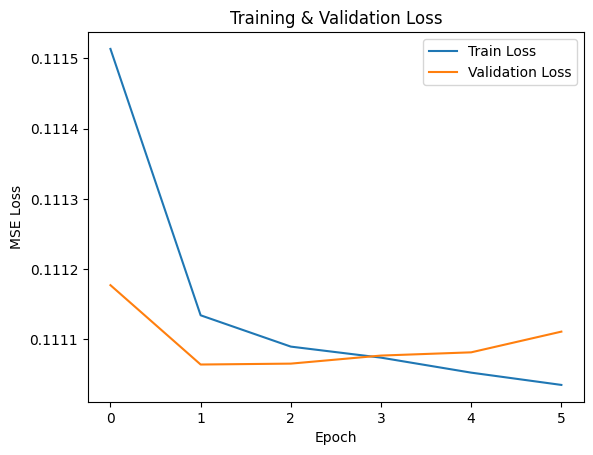

In [158]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [195]:
model.eval()
y_true_all, y_pred_all = [], []
x_test_all = []
test_loss = 0.0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to('cuda'), y_test.to('cuda')
        y_pred_test = model(x_test)
        loss = criterion(y_pred_test, y_test)
        test_loss += loss.item()
        x_test_all.append(x_test.cpu().numpy())
        y_true_all.append(y_test.cpu().numpy())
        y_pred_all.append(y_pred_test.cpu().numpy())
test_loss /= len(test_loader)
test_r2, test_pearson = compute_r2_pearson(y_true_all, y_pred_all)
print(f"Test MSE Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}, Test Pearson: {test_pearson:.4f}")

Test MSE Loss: 0.1112, Test R2: -0.0011, Test Pearson: -0.0001


[[1.812902  0.        0.        ... 0.        0.        1.2709123]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        1.7814181 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[[0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 ...
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


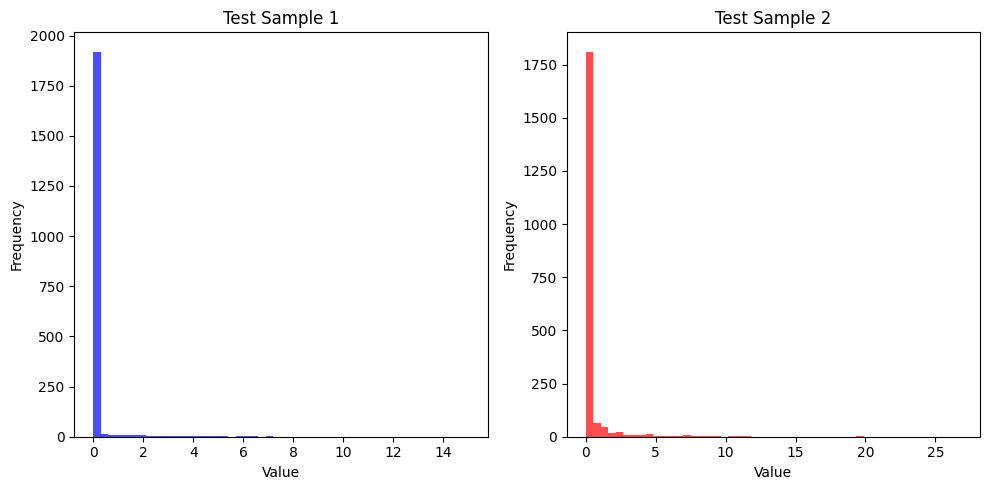

In [ ]:
# plot the two test samples as a histogram (they are embeddings)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(x_test_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[1].hist(x_test_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

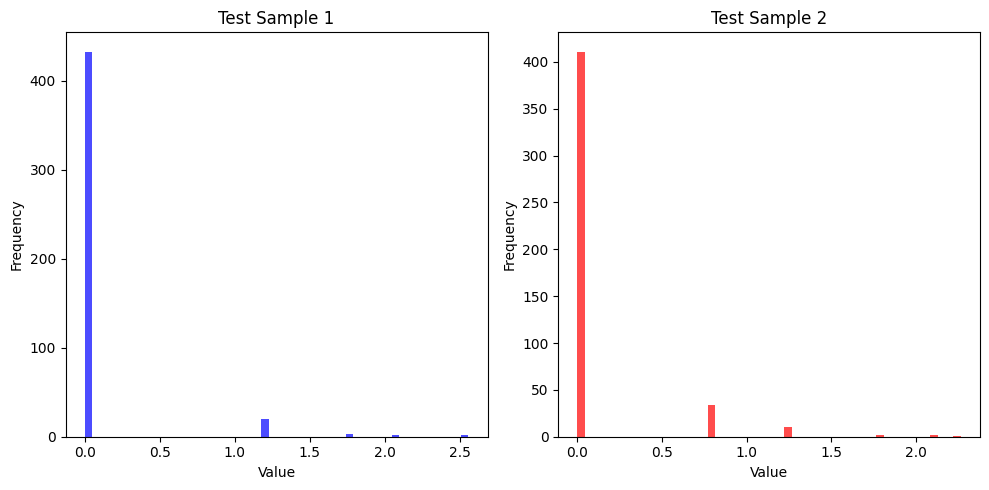

In [178]:
# plot the true expressions of two test samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(y_true_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[1].hist(y_true_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

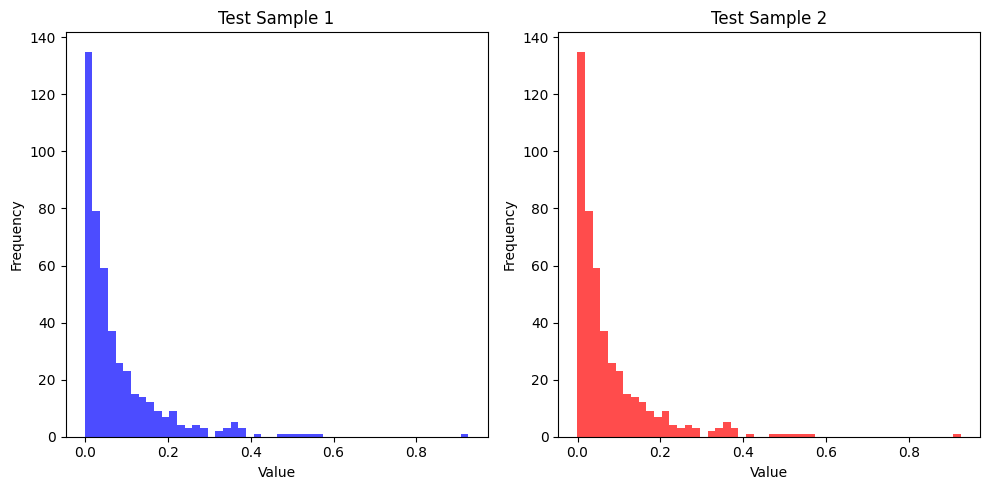

In [179]:
# plot the two predicted expressions of two test samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].hist(y_pred_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')  
axs[1].hist(y_pred_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [197]:
pearson = []
y_pred = np.vstack(y_pred_all)
y_true = np.vstack(y_true_all)
for i in range(y_true.shape[1]):
    corr, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
    pearson.append(corr)
mean_pearson = np.nanmean(pearson)

(460,)
(22379,)
R2 of expression vector:  0.020224690437316895
Pearson of expression vector:  0.18172315
R2 of some gene:  -9.548664093017578e-05
Pearson of some gene:  0.012561899


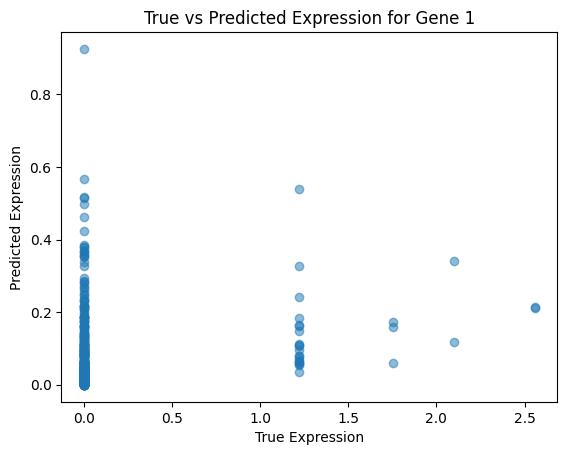

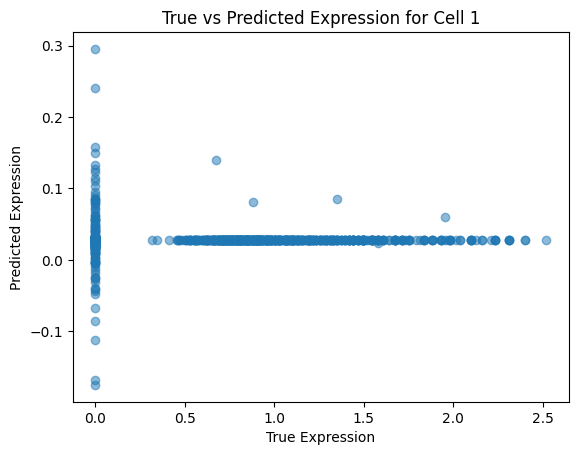

In [228]:
# print(y_pred[1,:])
print(y_true[1,:].shape)
print(y_pred[:,1].shape)

# r2 score of expression vectors
r2 = r2_score(y_true[1,:], y_pred[1,:])
p,_ = stats.pearsonr(y_true[1,:], y_pred[1,:])
print("R2 of expression vector: ", r2)
print("Pearson of expression vector: ", p)

r2 = r2_score(y_true[:,1], y_pred[:,1])
p,_ = stats.pearsonr(y_true[:,1], y_pred[:,1])
print("R2 of some gene: ", r2)
print("Pearson of some gene: ", p)

# plot the two predicted expressions of one test sample
plt.scatter(y_true[1,:], y_pred[1,:], alpha=0.5)
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('True vs Predicted Expression for Gene 1')
plt.show()

# plot the two predicted expressions of one test sample
plt.scatter(y_true[:,1], y_pred[:,1], alpha=0.5)
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('True vs Predicted Expression for Cell 1')
plt.show()

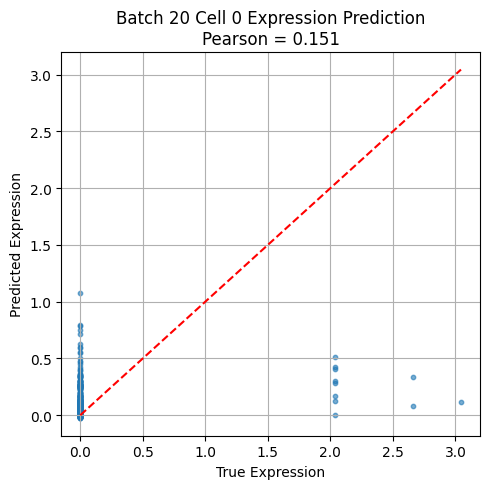

In [226]:
# Pick one cell (e.g., index 0)
batch_idx = 20
cell_idx = 0
y_true_vec = y_true_all[batch_idx][cell_idx]
y_pred_vec = y_pred_all[batch_idx][cell_idx]

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true_vec, y_pred_vec, alpha=0.6, s=10)
plt.plot([y_true_vec.min(), y_true_vec.max()], [y_true_vec.min(), y_true_vec.max()], 'r--')
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.title(f"Batch {batch_idx} Cell {cell_idx} Expression Prediction\nPearson = {np.corrcoef(y_true_vec, y_pred_vec)[0,1]:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()

(460,)
<class 'numpy.ndarray'>


/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


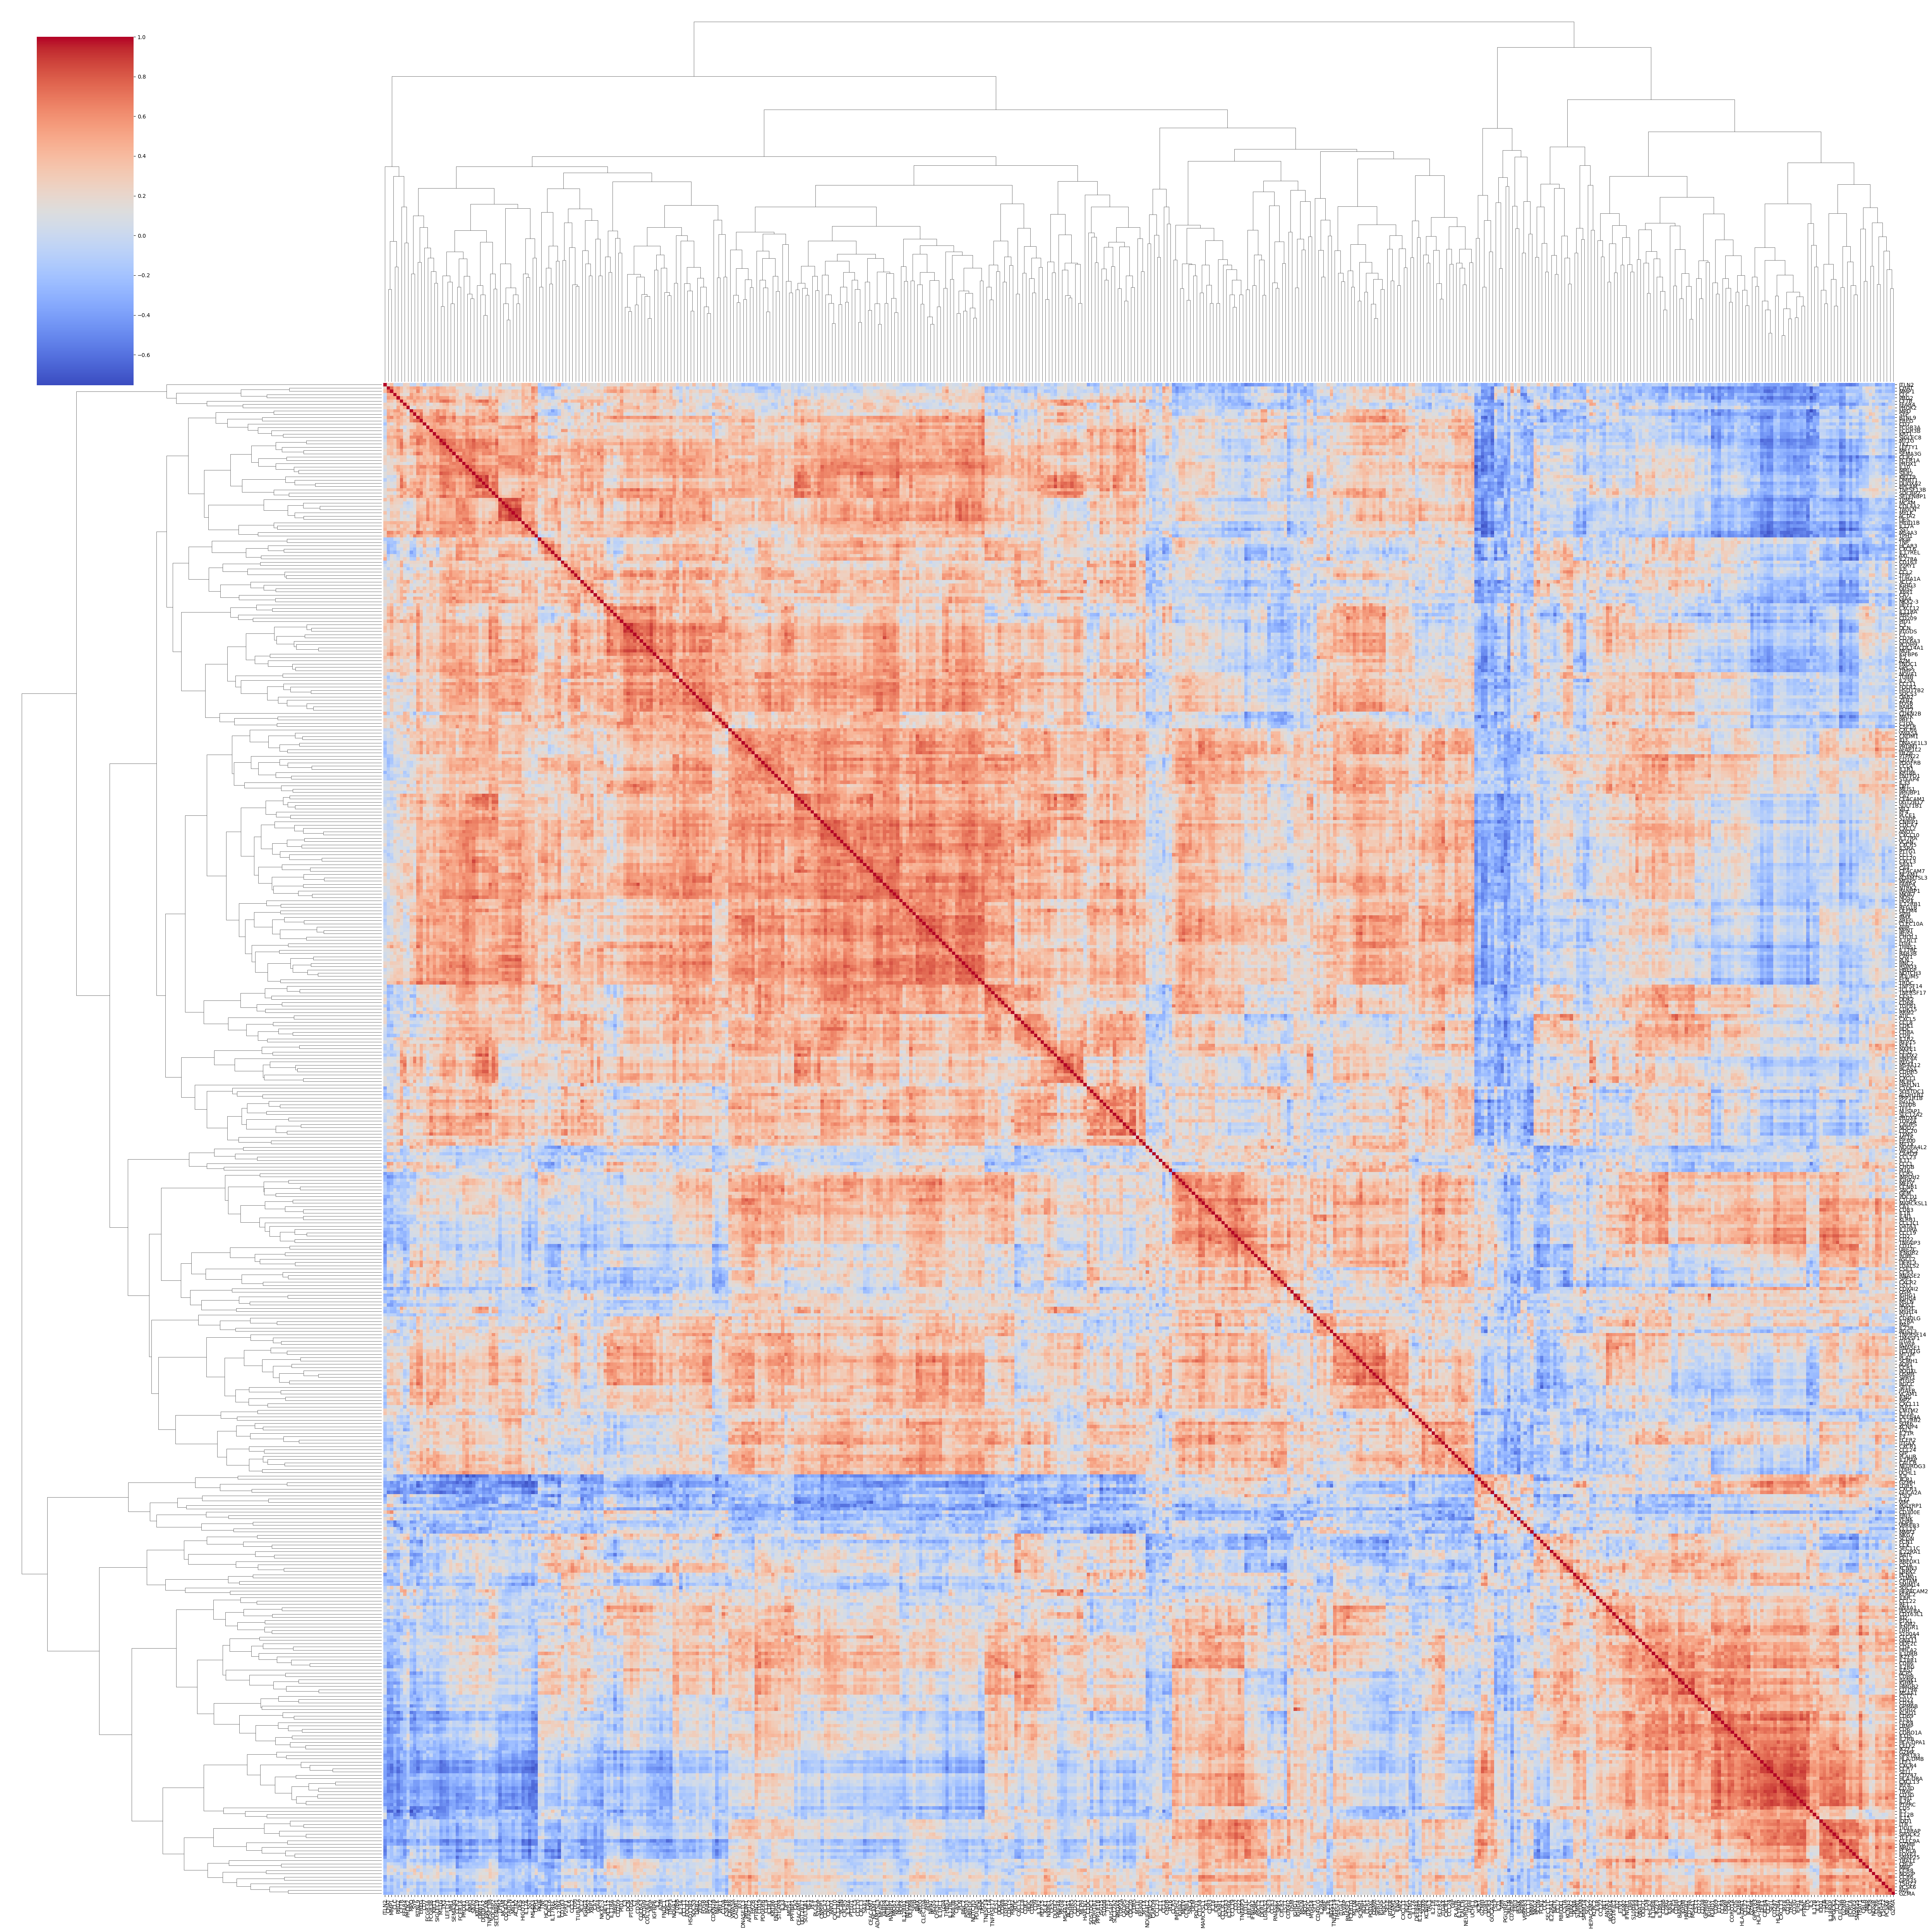

In [243]:
#can we use our prediction to make a gene heatmap??
# get the predicted expression for all cells
print(y_pred[1].shape)
print(type(y_pred))

gene_names = sdata['anucleus'].var['gene_symbols'].values
corr_matrix = np.corrcoef(y_pred.T)
# label with gene names and save a high resolution image, and enable clustering
sns.clustermap(
    corr_matrix,
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    xticklabels=gene_names,
    yticklabels=gene_names,
    figsize=(50, 50)
)

plt.savefig("gene_correlation_clustermap.png", dpi=300)
plt.show()

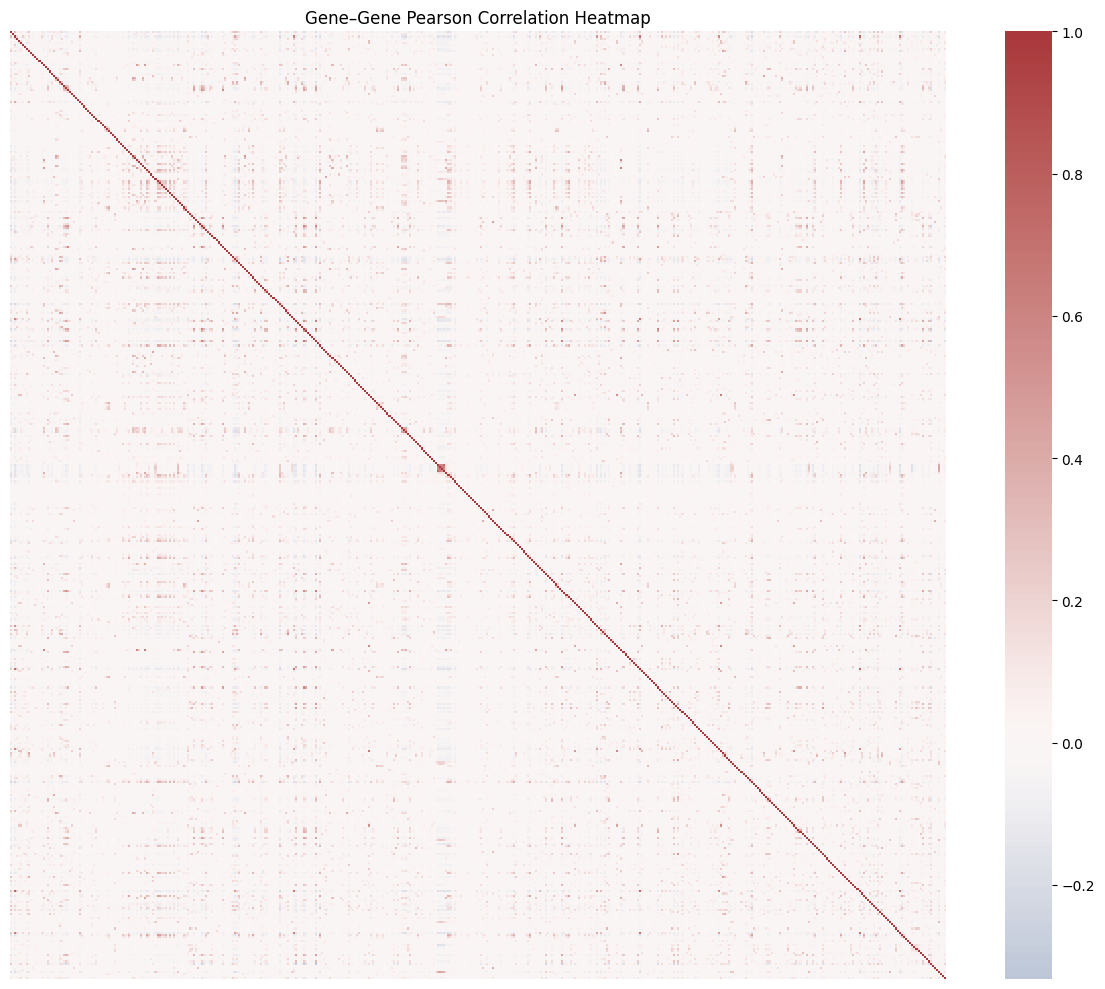

In [238]:
# now for the true expression??
corr_matrix = np.corrcoef(y_true.T)  # transpose: now shape (460, 460)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="vlag", center=0, xticklabels=False, yticklabels=False)
plt.title("Gene–Gene Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()

## Data Exploration

Let us explore what this object contains:

In [16]:
sdata

SpatialData object, with associated Zarr store: /home/b-evelyntong/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 20992)
│     └── 'HE_original': DataArray[cyx] (3, 20000, 20992)
└── Tables
      ├── 'anucleus': AnnData (223790, 460)
      └── 'cell_id-group': AnnData (308924, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

The object `sdata` contains two types of instances: `Images` and `Tables`.

The `Image` instance named `'HE_original'` is a 3d array with dimension $(3, 20000, 20992)$. Therefore it must be an RGB image (3 channels on the first dimension) with dimension $20000 \times 20992$. Let's see how it looks like:

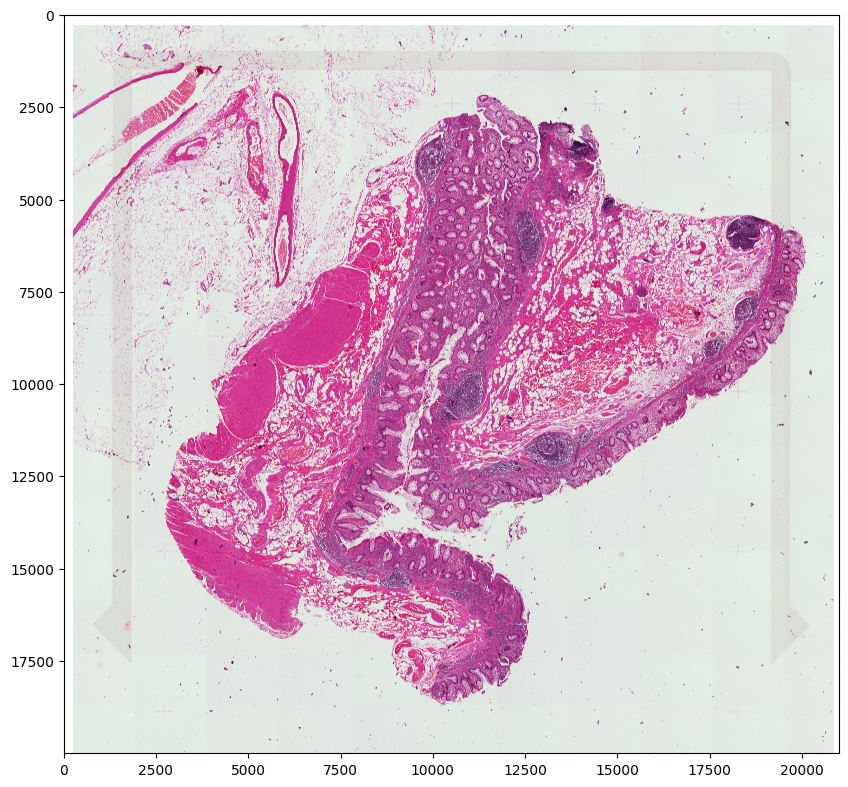

In [17]:
plt.figure(figsize=(10, 10))
transpose_image = np.transpose(sdata.images['HE_original'].to_numpy(), (1, 2, 0))
plt.imshow(transpose_image)
plt.show()

In [ ]:
print("Image resolution is",transpose_image.shape[0]*transpose_image.shape[1], "pixels")

Image resolution is 419840000 pixels


Let us now look at the entry `'HE_nuc_original'` in the `Image` instance. The description of `sdata` tells us that this is a 3d array with the same width and length as `'HE_original'` and only one channel for the pixel value.

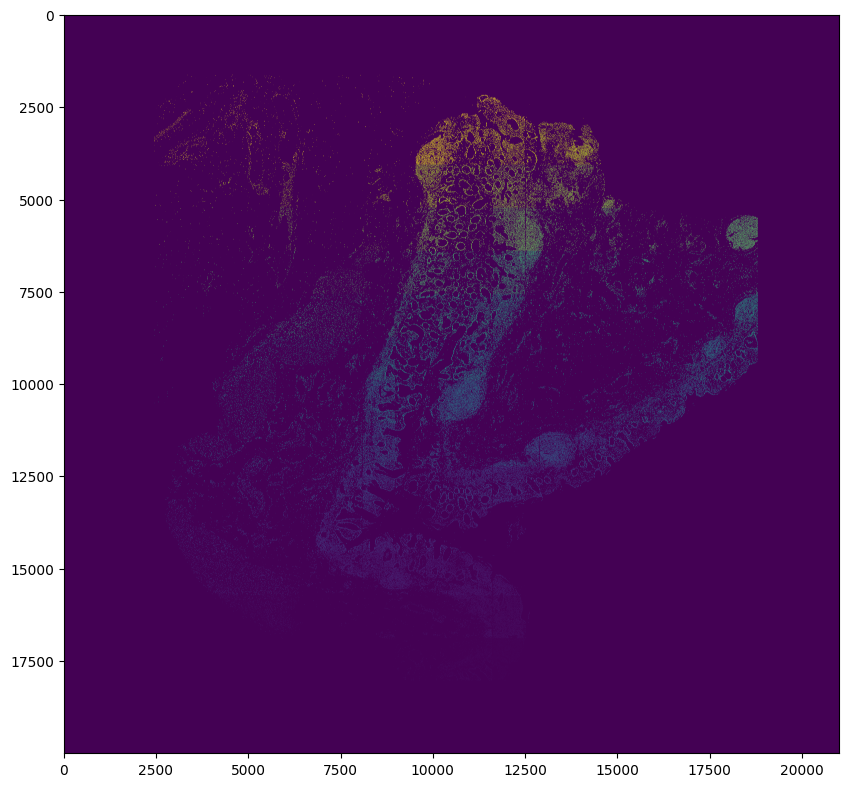

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(sdata.images['HE_nuc_original'].to_numpy()[0,:,:])
plt.show()

This is not super clear! Let's look at a smaller area of the image and compare this output with the original image

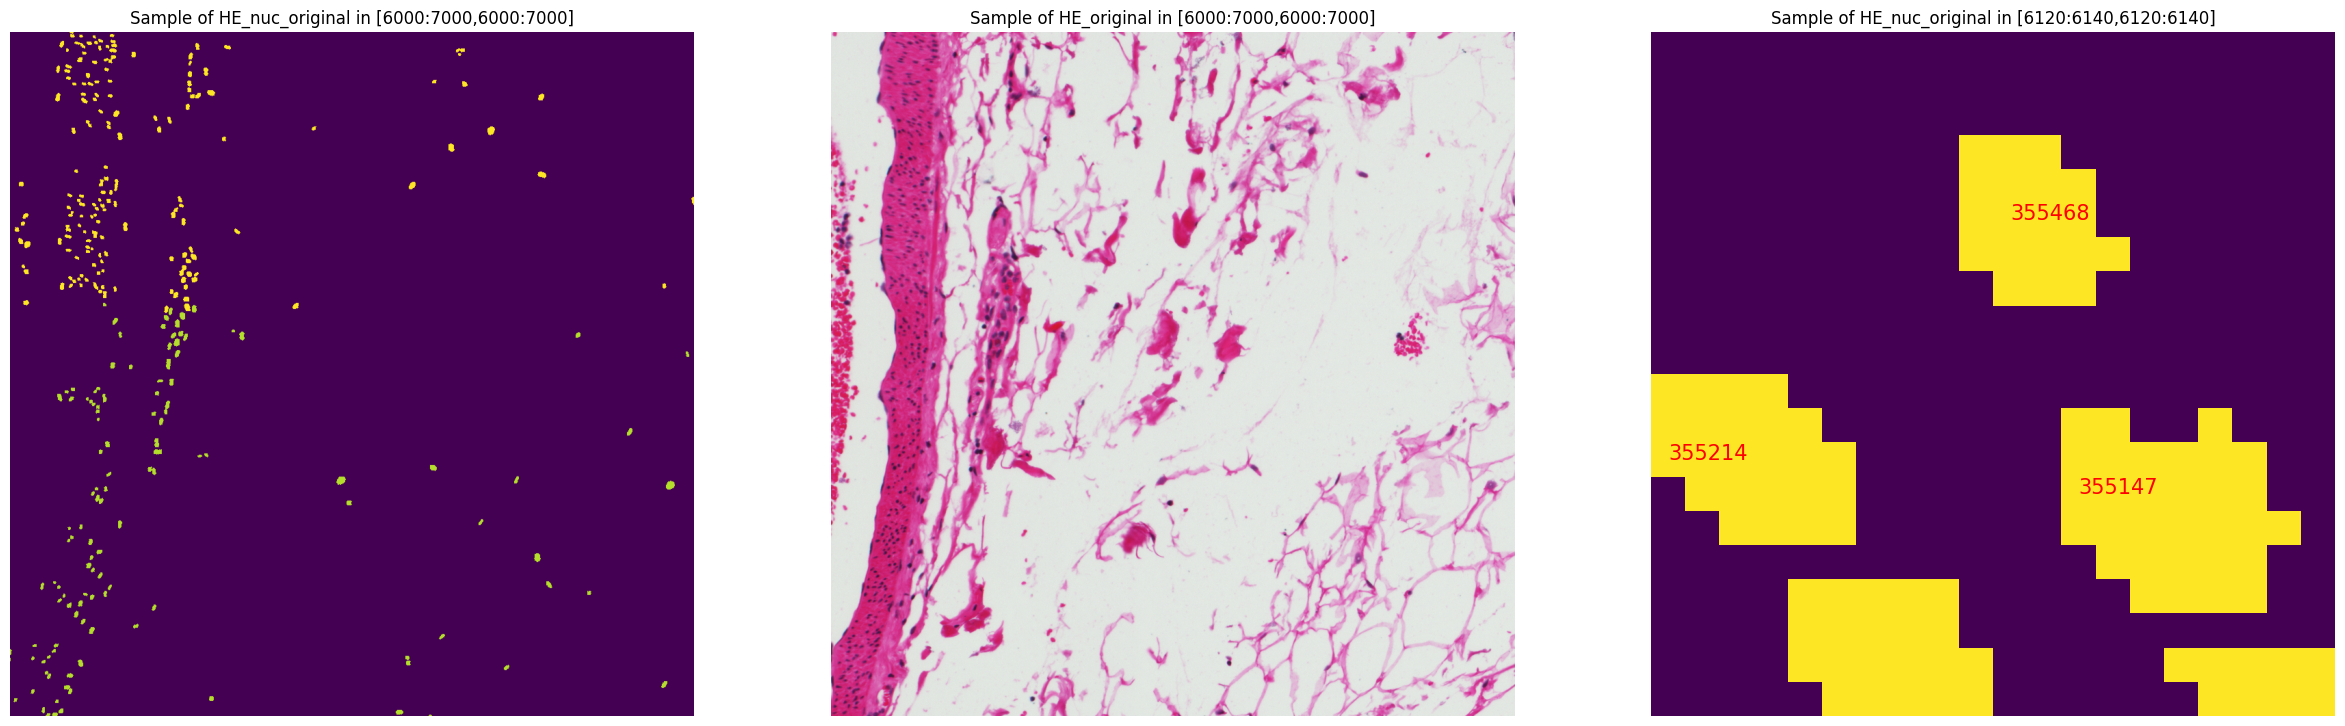

In [ ]:
he_nuc_original_sample = sdata["HE_nuc_original"].to_numpy()[0,6000:7000,6000:7000]
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(he_nuc_original_sample)
ax[0].axis("off")
ax[0].set_title("Sample of HE_nuc_original in [6000:7000,6000:7000]")
ax[1].imshow(transpose_image[6000:7000,6000:7000])
ax[1].axis("off")
ax[1].set_title("Sample of HE_original in [6000:7000,6000:7000]")
ax[2].imshow(he_nuc_original_sample[240:260,120:140]) #plotting the image in [6120:6140]
ax[2].axis("off")
ax[2].text(0,12,he_nuc_original_sample[240 + 12,120 + 0],fontsize=15,color = "red")
ax[2].text(10,5,he_nuc_original_sample[240+5,120 + 10],fontsize=15,color = "red")
ax[2].text(12,13,he_nuc_original_sample[240+12,120 + 13],fontsize=15,color = "red")
ax[2].set_title("Sample of HE_nuc_original in [6120:6140,6120:6140]")
plt.show()

This is now much clearer! The array `'HE_nuc_original'` is a mask that indicates the location of the cell nuclei in the image. The pixel value is either set to be 0 if there is no cell or equal to the cell nuclei id. It would be tempting to look at the maximum value of nuclei id in the array to infer the number of cells in the image, but it would be a hazardous process, since we don't know if the nuclei id are spaced incrementally...

Now let us look at the instance `Table` in `sdata`:

In [ ]:
sdata.tables["anucleus"]

AnnData object with n_obs × n_vars = 223790 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

In [ ]:
sdata.tables["anucleus"].X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.5781854, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 2.7963428, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.2091649, 0.       , 2.4690154, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

The X dataframe is the normalized gene expression matrix.

The table `anucleus`contains the cell ids, which we can access with the key `obs`:

In [ ]:
sdata.tables["anucleus"].obs.head()

cell_id
92       92
93       93
94       94
95       95
97       97

In [ ]:
print("There are", len(sdata.tables["anucleus"].obs), "cells identified and quantified in the image")

There are 223790 cells identified in the image


The `anucleus` table contains the key `var` which is associated with the genes measured in this experiment:

In [ ]:
sdata.tables["anucleus"].var.head()

gene_symbols
A2M               A2M
ACP5             ACP5
ACTA2           ACTA2
ADAMTSL3     ADAMTSL3
AFAP1L2       AFAP1L2

In [ ]:
print("There are", len(sdata.tables["anucleus"].var),"genes measured in this experiment.")

There are 460 genes measured in this experiment.


Then, we find that the table `anucleus` contains a key `obsm`, itself containing a unique key `spatial` which stores the following array:

In [ ]:
print(sdata.tables["anucleus"].obsm["spatial"])
print("This array has shape",sdata.tables["anucleus"].obsm["spatial"].shape)

[[25120.23969466  4197.8610687 ]
 [25087.67387033  3928.96660118]
 [25383.72636816  4410.71475954]
 ...
 [50715.87037037 54110.51851852]
 [50528.79213483 53837.87359551]
 [50431.78014184 54715.05319149]]
This array has shape (223790, 2)


In [ ]:
x,y = np.where(sdata.images["HE_nuc_original"].to_numpy()[0,:,:] == 92)
x_0,y_0 = np.mean(x),np.mean(y)

In [ ]:
25120/x_0,4197/y_0

(np.float64(1.3850639917717291), np.float64(0.37930213440438804))

The length of the array `spatial` is exactly the number of cells in the image. According to documentation, this dataframe seems to record the "spatial coordinates of the center of the nucleus ... based on the registered images (DAPI)", however we notice that the max, or dimension of this dataframe is ~50000 which is larger than the dimensions of the pixel intensity dataframe (`'HE_original'` and `'HE_nuc_original'`). We wondered if the organizer did some aspect rescaling for this data to obtain `'HE_nuc_original'` but the result didn't really support our hypothesis (we would've expected the two values to be the same, which is scaling factor)

We also notice that in the documentations in the original challenge, `obsm['spatial']` was overwritten during the processing with the output of some function on `'HE_nuc_original'`, which as we have seen above, is the mask of each cell. So for our purpose here we will omit the information provided in `obsm['spatial'`] as we technically have all the data we need to train our model.


The `counts` table in the `anucleus` data is an array containing the RNA counts cell by cell for every gene studied.

In [ ]:
print(sdata.tables["anucleus"].layers["counts"].shape)
print(sdata.tables["anucleus"].layers["counts"])

(223790, 460)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 4 ... 0 0 0]]


Finally, we look at the table `"cell_id_group"` and its key `obs`. It contains a dataframe reporting for every cell_id in the image if it is used for training or testing.

In [ ]:
sdata.tables["cell_id-group"].obs

cell_id  group
0            92  train
1            93  train
2            94  train
3            95  train
5            97  train
...         ...    ...
430002   312552   test
430005   312566   test
430007   312583   test
430010   312592   test
430013   312615   test

[308924 rows x 2 columns]

Here we explored just 1 of the 8 paired (image, transcriptome) datasets provided, note DC1 is a test dataset. We use sd.read_zarr(zarr_file_path) to load each file into a "Spatial Data" object in the notebook.

We can query this object via []. Both 'HE_nuc_original' and 'HE_original' returns image objects, where nuc returns 1 channel and the other one 3 channels. Probably nuc refers to the presegmented, nucleus mask for each histology image (so we can use it for our model if needed). Next, we can query 'anucleus', which returns an AnnData obeject, with 'obs', 'var', 'obsm', 'layers' attributes. 'obs' is the cell ids, 'var' is the genes (just ~400 in this case, normally there'd be ~20000, they either subsetted due to disease significance or used a sequencing method that only produced this many). 'layers' contains the 'counts' variable which seems to be the raw count of each gene inside each cell. Also, querying 'X' gives us a n_cell by n_gene matrix, which is the expression matrix that will be our output.

Querying for 'cell_id-group' gives us the test-train split for the cells in this sample. We will use this to construct our train and test datasets.

Above, we also visualized the cells on a spatial dimension. Note the two strips are not test cells, but probably data intensionally leftout for other reasons. The test groups are the square-ish patches in the plot, the image of which is plotted below the blue dot plot.

We aim to design a model that takes in the pixel values of the each cell and output their expression value (normalized) for the genes selected.

For length sake, we omit our analyses for the rest of the 8 datasets (which had the same structure), but for our project, we will repeat both the EDA and the pre-processing (which is really just normalizing the intensity data) for the other datasets as well

## Normalizing the intensity data

In [ ]:
sdata['HE_original'].to_numpy()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [ ]:
def normalize_he_original(sdata, image_key='HE_original', new_key='HE_normalized'):
    """
    takes in the sdata object, pulls the image object out, normalizes each pixel
    by dividing over 255, store it back into sdata, then returns the new sdata object.
    """
    # extract original image
    original = sdata.images[image_key]

    # convert to NumPy, normalize, then convert back
    intensity_image = np.transpose(original.to_numpy(), (1, 2, 0))
    normalized = intensity_image / 255.0
    normalized_cyx = np.transpose(normalized, (2, 0, 1))
    normalized_dask = da.from_array(normalized_cyx, chunks="auto")

    # build new DataArray
    da_norm = xr.DataArray(
        normalized_dask,
        dims=("c", "y", "x"),
        coords={
            "c": original.coords["c"],
            "y": original.coords["y"],
            "x": original.coords["x"]
        },
        attrs=original.attrs
    )

    # wrap as SpatialImage
    sdata.images[new_key] = SpatialImage(da_norm)

    return sdata

In [ ]:
sdata = normalize_he_original(sdata)
sdata["HE_normalized"].to_numpy()

## Discuss any potential data issues outlined in the MS2 spec and how these issues have been resolved
- Missingness \
We investigated 2 types of missingness in our data. Firstly, the DC1 sample does not have spatial transcriptomics data. Secondly, there exists held out regions in each set of samples where spatial transcriptomics data is not available, with UC7 I sample having a larger such region. We have concluded that these regions were intentionally held out 1) for contest testing purposes, and 2) for the model to generalize better in potential downstream fine tuning cases where transcriptomic data that are not spatially adjacent. In reality, spatial transcriptomics is very expensive to conduct. It is often unrealistic to get spatial transcriptomics data for every spot on a whole slide image. Therefore, these held-out regions do not introduce significant problems or NAs to our project.

- Data imbalance \
For this dataset to be representative, we would like it to represent spatial organizations of the colon at different statuses, including normal and diseased. To make sure that the dataset includes a comprehensive sample, we further investigated the subtypes of conditions where the samples are from. The dataset has 6 sets of ulcerative colitis (UC) IBD subtype and 2 diverticulitis (DC) disease. UC is the most common subtype of IBD and are good representations of how IBD disease can affect the spatial organization of the colon tissue. DC disease, on the other hand, does not have a substantial effect on the spatial organization of the tissue. Therefore, the DC samples can serve as a representation of the normal colon tissue. Given that our main research aim is related to treating IBD, we consider it sufficient to have most of our dataset focusing on the disease state, learning the image feature representations of the disease affected colon tissue, while also having a small subsample of the normal colon tissue to learn from.

- Feature scaling \
The images in our dataset come with different intensities and the gene expression values may vary significantly between genes. Following the convention of scaling RGB images, we divided the image values by 255 for each pixel to have values between 0 and 1. Then, we incorporated the normalized intensities into the spatial data object for easier accessing and further processing. For the spatial transcriptomics data, we normalized the gene expression values for each gene — which is already done in the datasets provided.

## Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease